<a href="https://colab.research.google.com/github/ueki5/colaboratory/blob/main/playground-021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
!pip install japanize-matplotlib | tail -n 1
!pip install plotly | tail -n 1

3,32,32
3,30,30
3,28,28


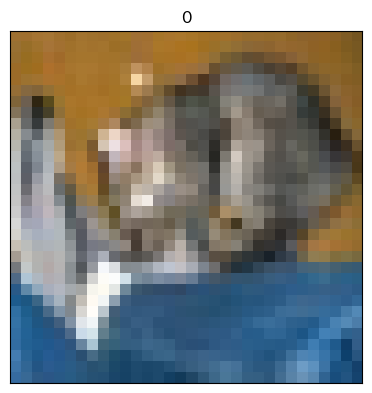

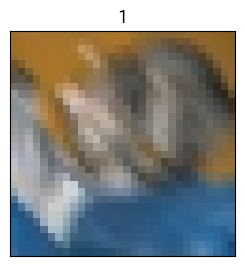

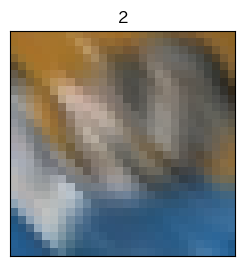

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import japanize_matplotlib
japanize_matplotlib.japanize()
from torch.utils.data import DataLoader
from datetime import datetime
from tqdm.notebook import tqdm
from pprint import pprint
from datetime import datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import japanize_matplotlib
japanize_matplotlib.japanize()
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchviz import make_dot


def tensor_to_pil(tensor, *, unnormalize=None, clip=True, convert_mode=None):
    """
    PyTorch Tensor -> PIL.Image.Image

    Args:
        tensor: torch.Tensor
            - shape can be (C,H,W), (H,W), (N,C,H,W) (then first item used), dtype float or uint8, on cpu or cuda
        unnormalize: callable or tuple(mean, std) or None
            - If tensor is normalized (e.g. ImageNet), pass (mean, std) to unnormalize each channel:
              unnormalize = (mean, std) where mean/std are sequences of length C.
            - Or pass a callable that maps tensor -> tensor (e.g. custom unnormalizer).
        clip: bool
            - Whether to clip final numeric values to valid range before converting to uint8.
        convert_mode: str or None
            - If you want to force PIL mode, e.g. 'RGB', 'L'. If None, infer from array shape.

    Returns:
        PIL.Image.Image
    """
    # 1.GPU → .cpu()
    # 2.計算グラフ → .detach()
    # 1) detach & cpu
    if isinstance(tensor, torch.Tensor):
        t = tensor.detach()
        if t.device.type != 'cpu':
            t = t.cpu()
    else:
        raise TypeError("Expected torch.Tensor")

    # 3.バッチ → tensor[0] or iterate
    # 4.(C,H,W) → (H,W,C)（permute(1,2,0)）
    # 2) if batch, take first element
    if t.ndim == 4:  # (N, C, H, W)
        t = t[0]

    # 3) squeeze channel if redundant
    if t.ndim == 3:
        c, h, w = t.shape
    elif t.ndim == 2:
        # (H, W) grayscale
        h, w = t.shape
        c = None
    else:
        raise ValueError(f"Unsupported tensor shape: {t.shape}")

    # 5.正規化を戻す（必要なら）
    # 4) optionally unnormalize (mean/std)
    if unnormalize is not None:
        if callable(unnormalize):
            t = unnormalize(t)
        else:
            # assume (mean, std)
            mean, std = unnormalize
            mean = torch.tensor(mean, dtype=t.dtype, device=t.device)
            std = torch.tensor(std, dtype=t.dtype, device=t.device)
            # if single channel mean/std, expand
            if mean.ndim == 0 or mean.shape[0] == 1:
                t = (t * std) + mean
            else:
                # (C,H,W) -> broadcast over H,W
                t = t * std[:, None, None] + mean[:, None, None]

    # 5) convert to numpy-friendly layout (H, W, C) or (H, W)
    if t.ndim == 3:
        # PyTorch: (C, H, W) -> NumPy/PIL: (H, W, C)
        arr = t.permute(1, 2, 0).numpy()
    else:
        arr = t.numpy()

    # 6.dtype とレンジを uint8 / 0..255 に整える
    # 6) decide range & dtype
    # Common cases:
    #  - float in [0,1]: multiply by 255 -> uint8
    #  - float in [0,255]: just clip/round -> uint8
    #  - uint8 already: pass through
    if arr.dtype == np.uint8:
        out = arr
    else:
        # float or other int types
        # heuristics: if float and max <= 1.0 -> treat as [0,1]
        if np.issubdtype(arr.dtype, np.floating):
            m = arr.max()
            M = arr.min()
            if m <= 1.0 + 1e-8 and M >= -1e-8:
                arr = arr * 255.0
            # sometimes tensors are in range [-1,1] (e.g. tanh outputs)
            elif m <= 1.0 and M < 0:
                arr = (arr + 1.0) / 2.0 * 255.0
            # otherwise assume already in 0..255-ish
        # cast to float64 for safe rounding
        arr = np.round(arr).astype(np.int64)
        if clip:
            arr = np.clip(arr, 0, 255)
        out = arr.astype(np.uint8)

    # 7) choose PIL mode
    if convert_mode is None:
        if out.ndim == 2:
            mode = 'L'  # grayscale
        elif out.shape[2] == 1:
            out = out[:, :, 0]
            mode = 'L'
        elif out.shape[2] == 3:
            mode = 'RGB'
        elif out.shape[2] == 4:
            mode = 'RGBA'
        else:
            # fallback: treat as RGB by truncation/padding
            if out.shape[2] > 4:
                out = out[:, :, :3]
                mode = 'RGB'
            else:
                # pad channels with zeros
                pad = 3 - out.shape[2]
                out = np.pad(out, ((0,0),(0,0),(0,pad)), mode='constant')
                mode = 'RGB'
    else:
        mode = convert_mode

    # 7.Image.fromarray(numpy_array) で PIL に変換
    # 8) to PIL
    # pil = Image.fromarray(out, mode=mode)
    pil = Image.fromarray(out)
    return pil

# Shortcut: use torchvision (works for many common cases)
def tensor_to_pil_torchvision(tensor):
    # torchvision.transforms.functional.to_pil_image handles many cases
    if tensor.device.type != 'cpu':
        tensor = tensor.cpu()
    if tensor.ndim == 4:
        tensor = tensor[0]
    return TF.to_pil_image(tensor)

# 畳み込み
def conv2d(data: torch.Tensor) -> torch.Tensor:
  (I, J, K) = data.shape
  print(f"{I},{J},{K}")
  ary = np.zeros((I, J - 2, K - 2), dtype = np.float32)
  for i in range(I):
    for j in range(1, J - 1):
      for k in range(1, K - 1):
        a = np.array([
          [data[i][j-1][k-1].item(), data[i][ j ][k-1].item(), data[i][j+1][k-1].item()],
          [data[i][j-1][ k ].item(), data[i][ j ][ k ].item(), data[i][j+1][ k ].item()],
          [data[i][j-1][k+1].item(), data[i][ j ][k+1].item(), data[i][j+1][k+1].item()],
        ], dtype=np.float32)
        b = np.array([
          [1, 0, 0],
          [0, 1, 0],
          [0, 0, 1],
        ], dtype=np.float32)
        ary[i][j-1][k-1] = np.sum(a * b) / sum(b.flatten())
  return torch.from_numpy(ary)

# ダウンロード先ディレクトリ名
data_root = './data'

# テンソル化 ＋ 正規化
transform = transforms.Compose([
  # データのテンソル化
  transforms.ToTensor(),
  # データの正規化(Normalize(μ, σ) ⇒ (x - μ) / σ)
  transforms.Normalize(0.5, 0.5),
])
# 検証データ
test_set = datasets.CIFAR10(
  root=data_root,
  train=False,
  download=True,
  transform=transform
)

data, label = test_set[0]

# 画像変換
ROW_NUM = 1
COL_NUM = 3

tensor = []
image = []
tensor.append(data)
image.append(tensor_to_pil(data))
for i in range(COL_NUM):
  tensor.append(conv2d(tensor[i]))
  image.append(tensor_to_pil(tensor[i+1]))

fig = plt.figure(figsize=(10, 5))
# plt.suptitle('イメージ比較')
for i in range(COL_NUM):
  ax = plt.subplot(1, 2, 2)
  plt.imshow(image[i])
  ax.set_title(f'{i}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()
